# Wiki's Whacky Covid Factory

-Wikipedia is one of the most accessed information websites. People look up topics related to the matter they are researching.

-Recently, one of the topics that was on everyone’s mind was the spread of fake news online. During the COVID lockdown, a period where everyone was home alone, speculations rose, and so did online gossip.

-We want to study the evolution of wiki article visits linked to fake news and see what they teach us.

-While information on Wikipedia is never explicitly labelled as “Fake” and extensive efforts were done to make the info as reliable as possible, we can still cluster articles related to a certain Fake news (eg: Hydroxychloroquine -> Covid treatments, horse medicine, FDA…)

-As such, page visits of properly clustered articles are a powerful tool to monitor interest related to a specific fake news, and whether it was used by users as a resource to fact check their data, or a way to go deeper down the rabbit hole doesn’t matter.

-We want to evaluate the usefulness of Wikipedia as a tool for studying misinformation. Let’s particularly focus on the COVID period (cause loads of misinformation, lots of data, the good stuff)

1. Can we use Wikipedia to identify the date of emergence of specific fake news? And what does it tell us about the public’s interest? Can we differentiate the increase in fake news interest from the general increase in traffic to wikipedia during the lockdown period?

2. Language related theories and fears -> World map of people’s hot topics (language based) -> International vs language specific fake news?

3. A timeline of main COVID fake news and their emergence across different countries. What is the link between mobility

### Libraries

In [ ]:
!pip install googletrans==4.0.0-rc1

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import json
import numpy as np
import requests
import matplotlib.pyplot as plt
import sys
import re
from bs4 import BeautifulSoup
from ast import literal_eval


# Antonio imports
from datetime import datetime, timedelta
from matplotlib.dates import AutoDateLocator, DateFormatter
import plotly.express as px
from pylab import  * 
import ast
from datetime import datetime, timedelta
# from dateutil.relativedelta import relativedelta
import statsmodels.formula.api as smf
import pandas as pd
import statsmodels
import numpy as np




from helpers.wiki_api_helpers import multi_lang_df, scrape_wikipedia_page, fetch_pageview_count, fetch_viewcount_df
from helpers.utils_helpers import spaces_to_underscore, normal_data

## **PART 0:** OMG check out this incredible TREND!!!! You won't believe your eyes


- Action 0.1: Plot the global Wikipedia trends, including the mobility data.
- Goal: Show that during the studied period (first half of 2020), there was an increase in Wikipedia interest. Extract the trend using the Top 100 articles, as the data from the article itself is not long enough. (By WILLIAM)


In [ ]:
####### WILLIAM'S CODE #######

- Action 0.2: Use the difference-in-differences (DiD) method to determine whether the increase in interest towards articles related to fake news is statistically significant compared to the average article.
- Goal: Show that studying the rise of fake news through Wikipedia might be interesting using William's code with Antonio's code.


- Action 0.3 -> Zoom into COVID related articles (“COVID 19 misinformation”), and do dif in dif with regards to global trend
- Goal -> Show that studying the rise of COVID related fake news through wikipedia might be particularly interesting WILLIAM with Antonio’s code


### A) Lets extract the global trend of wikipedia articles

We want to identify the global trend of wikipedia articles and remove them from our viewcount analysis. From the wikipedia Top 25 report, we can get the list of the 100 most viewed wikipedia articles yearly.

We extract those and plot their total views between 2019 and 2022

In [17]:
file_paths = [
    'Data/top100_articles/topviews-2019.csv',
    'Data/top100_articles/topviews-2020.csv',
]

# Read the CSV files into dataframes
dataframes = [pd.read_csv(file_path) for file_path in file_paths]

# Apply spaces_to_underscore function to the "Page" column of each dataframe
dataframes = [spaces_to_underscore(df, "Page") for df in dataframes]

# Useful dates
dates = [["20190101", "20191231"], ["20200101", "20201231"]]


In [ ]:
topviews_2019 = fetch_viewcount_df(df=dataframes[0], column="Page", language="en", start_date=dates[0][0], end_date=dates[0][1], granularity="daily")
topviews_2020 = fetch_viewcount_df(df=dataframes[1], column="Page", language="en", start_date=dates[1][0], end_date=dates[1][1], granularity="daily")

C:\Users\cpigu\AppData\Local\Temp\ipykernel_8956\3180845633.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  topviews_grouped = topviews.groupby('timestamp').median()


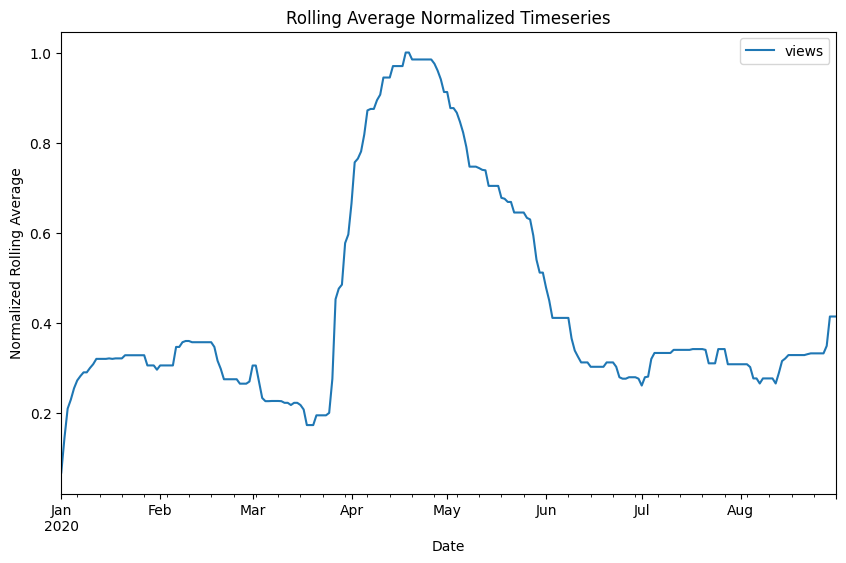

In [ ]:
start_date = "20200101"
end_date = "20200831"

topviews = pd.concat([topviews_2019, topviews_2020])
topviews_grouped = topviews.groupby('timestamp').median()
rolling_average = topviews_grouped.rolling(window=15, min_periods=1).median()
# Min-max normalization
rolling_average_normalized = (rolling_average - rolling_average.min()) / (rolling_average.max() - rolling_average.min())
rolling_average_normalized[start_date:end_date].plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Normalized Rolling Average')
plt.title('Rolling Average Normalized Timeseries')
plt.show()


## **PART 1:** Wiki, wiki, wiki, are you actually useful?

There are too many wikipedia articles, and too many ways of using the platform. Some people want to view articles as a way to confirm whether or not a fake news is fake, and some people might already be convinced and just want to feed their beliefs.

But that doesn't matter! Any interest is interesting for us, as they represent the emergence of viewing trends.

But first, we should be able to differentiate viewpage spikes which are fake news related, vs the normal trend...

#### Action 1.1
-	Action 1.1 -> Parse wikipedia “COVID 19 misinformation” page to obtain part names and sublinks. Group them according to the main topics of the wikipedia page (virus origin, incidence and mortality, disease spread, prevention, treatment, vaccine) PABLO
-	Goal -> Obtain a reliable group of articles directly related to COVID fake news
-	Add vaccine part


In [107]:
fetch_data = False
save_data = False
DATA_PATH = "./Data/dif_lang/"
if fetch_data:
    en = scrape_wikipedia_page("COVID-19_misinformation", language="en")
    if save_data:
        en.to_csv(DATA_PATH + "en.csv", index=False)
else:
    en = pd.read_csv(DATA_PATH + "en.csv")
    en['Full Links'] = en['Full Links'].apply(literal_eval)
    en['Links'] = en['Links'].apply(literal_eval)
    

In [108]:
en = en.drop(en[en["Main Heading"].isin(["Other", "Efforts to combat misinformation"])].index)

#### Action 1.2
-	Action 1.2 -> Do a selection of articles representative for us, and process the data so that outliers (such as very big weight articles such as Donald Trump) are eliminated. One might also find a way to remove the global trend PABLO
-	Goal -> Make the graphs plotted with the sum of articles related to main categories representative of general interest


In [115]:
def fetch_and_aggregate_views(article_urls, start_date, end_date, granularity="monthly", aggregation='mean'):
    """
    Fetches views for a list of Wikipedia articles and aggregates them.

    Parameters:
    article_urls (list): List of Wikipedia article URLs.
    start_date (str): Start date in YYYYMMDD format.
    end_date (str): End date in YYYYMMDD format.
    granularity (str): Granularity of data ('daily', 'monthly', etc.).
    aggregation (str): Type of aggregation ('mean', 'median', 'sum').

    Returns:
    pd.DataFrame: DataFrame with dates as columns and aggregated view counts.
    """

    # Extract article titles from URLs
    article_urls = [url.split('/')[-1].replace('_', ' ') for url in article_urls]

    # Fetch pageview data for each article
    all_views = []
    for title in article_urls:
        print(title)
        # Assuming fetch_pageview_count is a function that fetches page view data for a given title
        views_data = fetch_pageview_count("en", title, start_date, end_date, granularity)
        all_views.append(views_data)

    # Combine all views into a single DataFrame
    combined_df = pd.concat(all_views)

    # Pivot the DataFrame to have dates as columns
    pivoted_df = combined_df.pivot_table(index='article', columns='date', values='views')

    # Aggregate the data
    if aggregation == 'mean':
        result_df = pivoted_df.mean()
    elif aggregation == 'median':
        result_df = pivoted_df.median()
    elif aggregation == 'sum':
        result_df = pivoted_df.sum()

    return result_df.transpose()


In [116]:
article_urls = en['Links'][0]
type(article_urls)

list

In [117]:
# Example usage
result_df = fetch_and_aggregate_views(article_urls, '20200101', '20201231', granularity='monthly', aggregation='mean')

COVID-19 lab leak theory
Error fetching data for 2. Status Code: 400
Error fetching data for 0. Status Code: 400
Error fetching data for 2. Status Code: 400
Error fetching data for 0. Status Code: 400
Error fetching data for 0. Status Code: 400
Error fetching data for 1. Status Code: 400
Error fetching data for 0. Status Code: 400
Error fetching data for 1. Status Code: 400
Severe acute respiratory syndrome coronavirus 2
Error fetching data for 2. Status Code: 400
Error fetching data for 0. Status Code: 400
Error fetching data for 2. Status Code: 400
Error fetching data for 0. Status Code: 400
Error fetching data for 0. Status Code: 400
Error fetching data for 1. Status Code: 400
Error fetching data for 0. Status Code: 400
Error fetching data for 1. Status Code: 400
COVID-19
Error fetching data for 2. Status Code: 400
Error fetching data for 0. Status Code: 400
Error fetching data for 2. Status Code: 400
Error fetching data for 0. Status Code: 400
Error fetching data for 0. Status Code

TypeError: cannot concatenate object of type '<class 'dict'>'; only Series and DataFrame objs are valid

#### Action 1.3
-	Action 1.3 -> Introduce the news dataset. Identify which news are directly related to the main categories through bag of words methods. What overlap is there?
-	Goal -> Find a link between media coverage and Wikipedia page visits TECLA
-	Interest overlap 


In [40]:
source  = "Data/"
main_df = pd.read_csv(source+"news_dataset_cl.csv").copy()
df2 = main_df[["news_id","statement","fact_url", "label", "lang", "time", "Cluster"]].copy()


In [60]:
languages_analyze = ["en", "es","pt", "fr", "it"]
count_news        = []
for i in languages_analyze:
    df_lang = pd.DataFrame(df2[df2["lang"]==i].groupby("time")["news_id"].count())
    df_new = df_lang.rename(columns={'news_id': i})
    count_news.append(df_new)
result  = pd.concat(count_news, axis=1)
results = result.fillna(0)   
df = results

# Convert the 'time' index to a datetime format
df['time_1'] = pd.to_datetime(df.index, format='%d/%m/%Y')

df = df.sort_values(by='time_1')
# Example usage:
language = "en"
articles_list = ["Covid-19"]
start_date = "20200101"
end_date = "20201101"
result=fetch_pageview_count(language, articles_list, start_date, end_date)

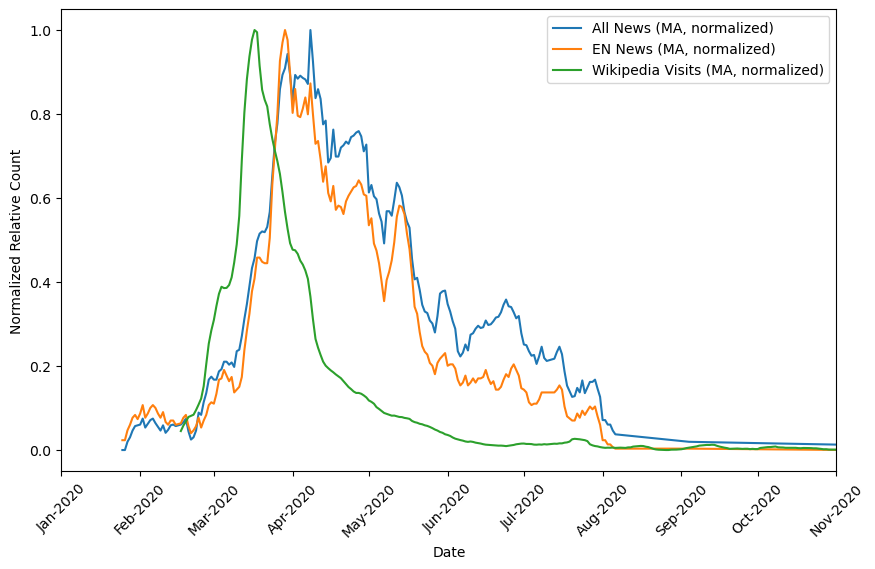

In [61]:
# Function to calculate moving average
def moving_average(series, window_size):
    return series.rolling(window=window_size).mean()

# Function for min-max normalization
def min_max_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Assuming df is your DataFrame with the time series data

# Convert the 'time' index to a datetime format
df['time_1'] = pd.to_datetime(df.index, format='%d/%m/%Y')
df = df.sort_values(by='time_1')

# Define a window size for the moving average
window_size = 7  # Example: 7 for a weekly moving average

# Calculate moving averages and normalize
df_ma = df.copy()
df_ma['all_news_ma'] = min_max_normalize(moving_average(df[languages_analyze].sum(axis=1), window_size))
df_ma['en_news_ma'] = min_max_normalize(moving_average(df['en'], window_size))

# Assuming 'result' has the Wikipedia visits data structured correctly
# Normalize Wikipedia visits moving average
result_ma = result.copy()
result_ma["Covid-19"]["views_ma_norm"] = min_max_normalize(moving_average(result["Covid-19"]["views"], window_size))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['time_1'], df_ma['all_news_ma'], label="All News (MA, normalized)")
plt.plot(df['time_1'], df_ma['en_news_ma'], label="EN News (MA, normalized)")

# Uncomment the below line to plot normalized Wikipedia visits (if structured correctly)
plt.plot(result["Covid-19"]["timestamp"], result_ma["Covid-19"]["views_ma_norm"], label="Wikipedia Visits (MA, normalized)")

plt.xlabel('Date')
plt.ylabel('Normalized Relative Count')
plt.xlim(datetime(2020, 1, 1), datetime(2020, 11, 1))
plt.gca().xaxis.set_major_formatter(DateFormatter('%b-%Y'))
plt.tick_params(axis='x', rotation=45)
plt.legend()
plt.show()


-	Action 1.4 -> Plot the final curves of news articles published vs wikipedia articles interest. Is there a correlation? PABLO + TECLA
-	Goal -> Study the relationship between media attention/Coverage and Wikipedia views
-	Statistical test to prove that? Jackart similarity of the different curves


### C) Identifying relevant articles

Not all the parts of the article are interesting and give relevant information. We do a pre selection 

In [ ]:
def getSubLinksFromIntroPablo(links):
    views = []
    for link in links:
        result = fetch_pageview_count("en", link)
        if(len(result) != 0):
            views.append(result)

    return views[0]
 
def existed(article, dateMin="2020-03-01"):
    #check if the first timestamp is less dateMin 
    if pd.Timestamp(article.iloc[0]['timestamp']) <= pd.Timestamp(dateMin):
        return True
    else:
        return False  

def getSubLinksFromIntro(website, nombreMax=10):
    link = "https://en.wikipedia.org/wiki/"+website

    #load online the html file 
    r = requests.get(link)
    soup = BeautifulSoup(r.text, 'html.parser')

    intro = soup.find_all('div', attrs={'class':'mw-content-ltr mw-parser-output'})[0].find_all('p')
    #get the all the href
    links = []
    for i in intro:
        #get the link and not the <a> tag
        try:
            currentLink = i.find_all('a', href=True)[0]['href']
            if(currentLink[0] == '#'):
                continue
            links.append(currentLink)
        except:
            pass

        if(len(links) >= nombreMax):
            break
    
    return links

class wikiTopic:
    df = []

    links = []
    dfView = []
    dfViewFinal = []

    dfSubLinks = []
    dfViewSubLinks = []
    dfViewSubLinksFinal = []

    def __init__(self, df, Maintopic):

        self.dfView = []
        self.dfViewFinal = []
        self.dfViewSubLinks = []
        self.dfViewSubLinksFinal = []
        
        indexes = df["Main Heading"]==Maintopic
        self.df = df[indexes]

        self.extractLinksFromDf()
        self.getViews()

        self.getSublinks()
        #self.getViewsSubLinks()

    def extractLinksFromDf(self):

        linksFinal = []
        for links in self.df.Links:
            links = links[1:-1]
            links = links.split(',')

            links = [re.sub(r'[\[\]\'\s]', '', link) for link in links]
            links = [re.sub(r'/wiki/', '', link) for link in links]
            #concatenate the list
            linksFinal = linksFinal + links
        
        self.links = list(set(linksFinal))

    def getViews(self):
        #fetch view counts
        viewsdf = getSubLinksFromIntroPablo([self.links])
        keys = list(viewsdf.keys())
        #make a list of df 
        for i in range(len(keys)):
            if(existed(viewsdf[keys[i]])):
                self.dfViewFinal.append(viewsdf[keys[i]])
            self.dfView.append(viewsdf[keys[i]])
            
    

    def getSublinks(self):
        for i in range(len(self.links)):
            allSublinks = getSubLinksFromIntro(self.links[i])
            allSublinks = [re.sub(r'/wiki/', '', link) for link in allSublinks]
            #if the sublinks have "#cite_" remove them 
            allSublinks = [link for link in allSublinks if "#cite_" not in link]
            self.dfSubLinks = self.dfSubLinks + allSublinks

        self.dfSubLinks = list(set(self.dfSubLinks))

    def getViewsSubLinks(self):
        #fetch view counts
        viewsdf = getSubLinksFromIntroPablo(self.dfSubLinks)
        keys = list(viewsdf.keys())
        #make a list of df 
        for i in range(len(keys)):
            if(existed(viewsdf[keys[i]])):
                self.dfViewSubLinksFinal.append(viewsdf[keys[i]])
            self.dfViewSubLinks.append(viewsdf[keys[i]])




## **PART 2:** ¿Hablas Fake News?



-	Action 2.1 -> How did people’s fake news focus evolve with mobility? More interest in spread? In politics and stuff? VICTOR
-	Goal -> Study link between mobility restrictions and fake news interest


-	Action 2.2 -> Study “Covid 19 misinformation” pages for other languages as well. Extract the subparts and classify them into the same 5 main categories as the english one VICTOR
-	Goal -> Obtain the same dataset for other languages


In [25]:
fetch_data = False
save_data = False
DATA_PATH = "./Data/dif_lang/"
if fetch_data:
    url = "https://en.wikipedia.org/wiki/COVID-19_misinformation"
    languages = ['fr', 'es', 'it'] # List of desired language codes
    headings_df = multi_lang_df(url, languages)
    fr = headings_df["fr"]
    es = headings_df["es"]
    it = headings_df["it"]
    if save_data:
        fr.to_csv(DATA_PATH + "fr.csv", index=False)
        es.to_csv(DATA_PATH + "es.csv", index=False)
        it.to_csv(DATA_PATH + "it.csv", index=False)
else:
    en = pd.read_csv('Data/dif_lang/en.csv')
    fr = pd.read_csv('Data/dif_lang/fr.csv')
    es = pd.read_csv('Data/dif_lang/es.csv')
    it = pd.read_csv('Data/dif_lang/it.csv')

-	Action 2.3 -> Overlap of news topics between languages
-	Compare those results with wikipedia node graph of overlap of wiki articles per category


-	Action 2.4 -> Find a way to represent the interactions between the different languages -> Plot the interest curves? 
-	Timeseries, Venn diagram, node thing?
